## Sensitivity analysis for orbital relative motion with Clohessy–Wiltshire equations


We will focus on modelling orbital relative motion with the Clohessy-Wiltshire equations. This set of equations was taught in AA 528 and consist of a linear set of differential equations, making them easier to implement compared to the 6 degrees-of-freedom nonlinear equations of the Lunar Lander presented in [1]. This allows us to implement the sensitivity analysis concept from [1] to a new dynamical system.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [28]:
#### Define Constants ####

mu = 3.9860 * 10**5 #Earths gravitational parameter
R_Target = 400 
R_Earth = 6378 
R_total = R_Earth + R_Target
omega = np.sqrt(mu / R_total**3)

In [51]:
#### Initial Conditions #### 

r_init = np.array([1, 0, 1])
rdot_init = np.array([0.1, 0, 0])


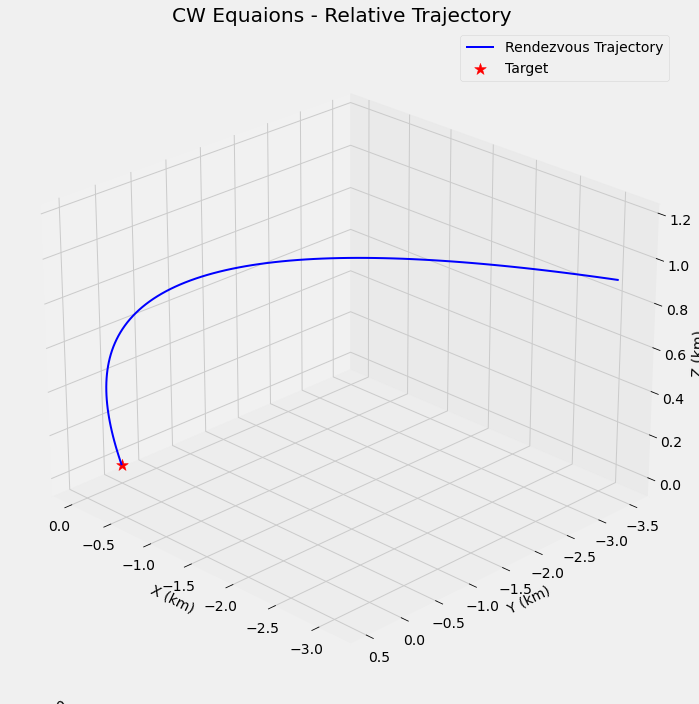

In [59]:
#### Analytical CW equations ####
def cw_state_transition_matrix(omega, t):
    c = np.cos(omega * t)
    s = np.sin(omega * t)

    phi = np.array([
        [4 - 3*c,      0,          0,     s/omega,          (2*(1-c))/omega,      0],
        [6*(s - omega*t), 1,       0,   -(2*(1-c))/omega,   -(4*s - 3*omega*t)/omega, 0],
        [0,            0,          c,     0,               0,                s/omega],
        [3*omega*s,    0,          0,     c,               -2*s,              0],
        [-6*omega*(1-c),0,          0,    -2*s,            -3 + 4*c,          0],
        [0,            0,     omega*s,   0,               0,                 c]
    ])
    return phi

# Function to propagate state using CW matrix defined above
def propagate_CW(r0, v0, omega, t):
    state0 = np.concatenate((r0, v0))
    phi = cw_state_transition_matrix(omega, t)
    state_t = phi @ state0
    r_t = state_t[:3]
    v_t = state_t[3:]
    return r_t, v_t

# Maneuver calculation for rendezvous. See equations 59-62 of [2] for further detail.
def calculate_maneuver(r_current, v_current, omega, t_go, r_target=np.array([10,1,1])):
    
    c = np.cos(omega * t)
    s = np.sin(omega * t)
    
    phi_rr = np.array([
        [4 - 3*c,      0,          0],
        [6*(s - omega*t), 1,       0],
        [0,            0,          c]
    ])
    phi_rv = np.array([
        [s/omega,      0,          0],
        [6*(s - omega*t), 1,       0],
        [0,            0,          c]
    ])
    phi_vr = np.linalg.pinv(phi_rv) 
    delta_v  = phi_vr @ (r_target - phi_rr @ r_current)
    return delta_v

# Simulation details
dt = 20
t1 = 10000
r1, v1 = propagate_CW(r_init, rdot_init, omega, t1)

# The first manuever for correction
t2 = 2000
delta_v1 = calculate_maneuver(r1, v1, omega, t2+t2)
new_v1 = v1 + delta_v1

# Use this new velocity to propogate system again 
r2, v2 = propagate_CW(r1, new_v1, omega, t2)

# Repeat until we compute the final velocity
delta_v2 = calculate_maneuver(r2, v2, omega, t2)
new_v2 = v2 + delta_v2
t3 = t2
r_final = []
times = np.arange(0, t3, dt)

for t in times:
    r_t, _ = propagate_CW(r2, new_v2, omega, t)
    r_final.append(r_t)

r_final = np.array(r_final)

# Plot the final trajectory
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*r_final.T, color='blue', linewidth=2, label='Rendezvous Trajectory')

# Plot the target, defined at origin
ax.scatter(0,0,0, color='red', marker='*', s=150, label='Target')

# Labels
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title('CW Equaions - Relative Trajectory')
ax.legend()
ax.grid(True)
ax.view_init(elev=25, azim=135)
plt.tight_layout()
plt.show()


References: 

[1] https://ntrs.nasa.gov/api/citations/20160014013/downloads/20160014013.pdf 
[2] https://nhsjs.com/wp-content/uploads/2024/08/Satellite-Rendezvous-Scheme.pdf